## 📦 Required Libraries and Modules

This section imports the necessary libraries and modules for data processing, model building, evaluation, and visualization.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,MinMaxScaler
import arviz as az
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import plotly.express as px
from chart_studio import plotly
import plotly as py
import plotly.graph_objects as go
from itertools import cycle
from plotly.subplots import make_subplots
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import plotly.io as pio
from IPython.display import display
pio.renderers.default = 'notebook_connected'
pio.renderers.default = 'colab'
pio.renderers.default = 'png'  # Set default to PNG for static export
warnings.filterwarnings('ignore')

# 📥 Data Collection

## 🗂 Source of the Data
The data used in this project is collected using the `yfinance` Python library, which fetches historical financial market data directly from Yahoo Finance.

## 🔍 Description of the Dataset
- **Ticker Used:** `BTC-USD` (Bitcoin to US Dollar)
- **Data Source:** Yahoo Finance via the `yfinance` API
- **Time Range:** As defined in the code (e.g., from `start = "2023-01-01"` to `end = "2025-01-25"`)

In [2]:
crypto_data=yf.download("BTC-USD", start="2023-01-01", end="2025-01-25")
crypto_data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2023-01-01,16625.080078,16630.439453,16521.234375,16547.914062,9244361700
2023-01-02,16688.470703,16759.343750,16572.228516,16625.509766,12097775227
2023-01-03,16679.857422,16760.447266,16622.371094,16688.847656,13903079207
2023-01-04,16863.238281,16964.585938,16667.763672,16680.205078,18421743322
2023-01-05,16836.736328,16884.021484,16790.283203,16863.472656,13692758566
...,...,...,...,...,...
2025-01-20,102016.664062,109114.882812,99471.359375,101083.750000,126279678351
2025-01-21,106146.265625,107180.921875,100103.953125,102052.578125,88733878242


## 🧹 Data Cleaning and Preparation

### 🏷️ Column Formatting
- `crypto_data.columns = [col[0] for col in crypto_data.columns]`  
  This line simplifies multi-level column headers (in case the data has them) by keeping only the top-level column names.

### 🔄 Resetting and Renaming Index
- `crypto_data.reset_index(inplace=True)`  
  Resets the index so the 'Date' becomes a regular column again.
- `crypto_data.rename(columns={'index': 'Date'}, inplace=True)`  
  Renames the newly created 'index' column back to 'Date' for clarity.

### 📆 Setting Date as Index
- `crypto_data.set_index('Date', inplace=True)`  
  Sets the 'Date' column as the index of the DataFrame — useful for time-series analysis and plotting.

In [3]:
#data.columns = ['_'.join(col) for col in data.columns]
crypto_data.columns=[col[0] for col in crypto_data.columns]
# Reset the index and rename
crypto_data.reset_index(inplace=True)
crypto_data.rename(columns={'index': 'Date'}, inplace=True)

# Set 'Date' as the index
crypto_data.set_index('Date', inplace=True)
columns_to_keep = ['Close', 'High', 'Low','Open','Volume']
crypto_data = crypto_data[columns_to_keep]

In [4]:
crypto_data

,Close,High,Low,Open,Volume
Date,,,,,
2023-01-01,16625.080078,16630.439453,16521.234375,16547.914062,9244361700
2023-01-02,16688.470703,16759.343750,16572.228516,16625.509766,12097775227
2023-01-03,16679.857422,16760.447266,16622.371094,16688.847656,13903079207
2023-01-04,16863.238281,16964.585938,16667.763672,16680.205078,18421743322
2023-01-05,16836.736328,16884.021484,16790.283203,16863.472656,13692758566
...,...,...,...,...,...
2025-01-20,102016.664062,109114.882812,99471.359375,101083.750000,126279678351
2025-01-21,106146.265625,107180.921875,100103.953125,102052.578125,88733878242
2025-01-22,103653.070312,106294.343750,103360.265625,106136.382812,53878181052


## 📈 Feature Engineering: Returns & Moving Averages

To better understand Bitcoin's price behavior and enhance the dataset for analysis and modeling, several new features are created:

### 🔁 Percentage Returns
- `Weekly_Return`:  
  - Calculated using `.pct_change(periods=7)` on the `Close` price.  
  - Measures the **percentage change in price over a 7-day period**.
- `Monthly_Return`:  
  - Calculated similarly with `periods=30`.  
  - Reflects the **30-day price return**, capturing longer-term trends.

> These features help in identifying short-term and medium-term trends in price movements.

### 🧹 Data Type Conversion
- `pd.to_numeric(..., errors='coerce')`:  
  - Ensures that return columns are treated as numeric types.  
  - Any invalid data (e.g., NaNs or strings) are safely converted to `NaN`.

### 📊 Simple Moving Averages (SMA)
- `SMA_7`:  
  - The **7-day simple moving average** of the closing price.
  - Smooths short-term price fluctuations for trend analysis.
- `SMA_30`:  
  - The **30-day simple moving average** gives insight into the longer-term trend.

In [5]:
crypto_data['Weekly_Return'] = crypto_data['Close'].pct_change(periods=7)
crypto_data['Monthly_Return'] = crypto_data['Close'].pct_change(periods=30)
crypto_data['Weekly_Return'] = pd.to_numeric(crypto_data['Weekly_Return'], errors='coerce')
crypto_data['Monthly_Return'] = pd.to_numeric(crypto_data['Monthly_Return'], errors='coerce')
crypto_data['SMA_7'] = crypto_data['Close'].rolling(window=7).mean()
crypto_data['SMA_30'] = crypto_data['Close'].rolling(window=30).mean()
crypto_data.head()

,Close,High,Low,Open,Volume,Weekly_Return,Monthly_Return,SMA_7,SMA_30
Date,,,,,,,,,
2023-01-01,16625.080078,16630.439453,16521.234375,16547.914062,9244361700,NaN,NaN,NaN,NaN
2023-01-02,16688.470703,16759.343750,16572.228516,16625.509766,12097775227,NaN,NaN,NaN,NaN
2023-01-03,16679.857422,16760.447266,16622.371094,16688.847656,13903079207,NaN,NaN,NaN,NaN
2023-01-04,16863.238281,16964.585938,16667.763672,16680.205078,18421743322,NaN,NaN,NaN,NaN
2023-01-05,16836.736328,16884.021484,16790.283203,16863.472656,13692758566,NaN,NaN,NaN,NaN


## 🧾 Dataset Overview
**Information of Dataset:**
- Show data types, non-null counts, and memory usage with `info()`.

In [6]:
crypto_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2023-01-01 to 2025-01-24
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           755 non-null    float64
 1   High            755 non-null    float64
 2   Low             755 non-null    float64
 3   Open            755 non-null    float64
 4   Volume          755 non-null    int64  
 5   Weekly_Return   748 non-null    float64
 6   Monthly_Return  725 non-null    float64
 7   SMA_7           749 non-null    float64
 8   SMA_30          726 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 59.0 KB


## 🧹 Finding Missing Data
**Purpose:**
- Detect and optionally remove or fill missing values using `isnull()`, `sum()`.

In [7]:
crypto_data.isnull().sum()

Close              0
High               0
Low                0
Open               0
Volume             0
Weekly_Return      7
Monthly_Return    30
SMA_7              6
SMA_30            29
dtype: int64

## 🛠️ Feature Engineering: Volatility and Directional Indicators

This section enhances the dataset with features that capture **market momentum, volatility, and trading behavior**, which are especially useful in predictive modeling.

### 🔄 Percentage Change Function
- `find_perchange_givencolumn(df, column_name)`:
  - A custom helper function that returns the **percentage change** of any given column.
  - Used to streamline repeated calculations.

### 📊 Added Features

- **`Close gap`**:  
  - Daily percentage change in the closing price.  
  - Measures volatility and helps detect price swings.

- **`High gap`**:  
  - Daily percentage change in the highest price of the day.

- **`Low gap`**:  
  - Daily percentage change in the lowest price of the day.

- **`Volume gap`**:  
  - Daily percentage change in trading volume — helps track market interest and sentiment.

- **`Daily change`**:  
  - Calculated as: `(Close - Open) / Open`  
  - Represents the relative price movement from market open to close each day.  
  - Often used to capture intraday bullish or bearish sentiment.

- **`Next day direction`**:  
  - Defined as: `Volume.shift(-1) - Volume`  
  - This is a **forward-looking feature** showing whether trading activity increased or decreased the next day.  
  - It can be a proxy for predicting future market interest.

In [8]:
# generating random sequences of data
# Adding new features to train_test_data
def find_perchange_givencolumn(df, column_name):
    return df.loc[:, column_name].pct_change()

crypto_data['Close gap'] = find_perchange_givencolumn(crypto_data, 'Close')
crypto_data['High gap'] = find_perchange_givencolumn(crypto_data, 'High')
crypto_data['Low gap'] = find_perchange_givencolumn(crypto_data, 'Low')
crypto_data['Volume gap'] = find_perchange_givencolumn(crypto_data, 'Volume')
crypto_data['Daily change'] = (crypto_data['Close'] - crypto_data['Open']) / crypto_data['Open']
crypto_data['Next day direction'] = crypto_data['Volume'].shift(-1) - crypto_data['Volume']

crypto_data

,Close,High,Low,Open,Volume,Weekly_Return,Monthly_Return,SMA_7,SMA_30,Close gap,High gap,Low gap,Volume gap,Daily change,Next day direction
Date,,,,,,,,,,,,,,,
2023-01-01,16625.080078,16630.439453,16521.234375,16547.914062,9244361700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004663,2.853414e+09
2023-01-02,16688.470703,16759.343750,16572.228516,16625.509766,12097775227,NaN,NaN,NaN,NaN,0.003813,0.007751,0.003087,0.308665,0.003787,1.805304e+09
2023-01-03,16679.857422,16760.447266,16622.371094,16688.847656,13903079207,NaN,NaN,NaN,NaN,-0.000516,0.000066,0.003026,0.149226,-0.000539,4.518664e+09
2023-01-04,16863.238281,16964.585938,16667.763672,16680.205078,18421743322,NaN,NaN,NaN,NaN,0.010994,0.012180,0.002731,0.325012,0.010973,-4.728985e+09
2023-01-05,16836.736328,16884.021484,16790.283203,16863.472656,13692758566,NaN,NaN,NaN,NaN,-0.001572,-0.004749,0.007351,-0.256707,-0.001585,7.209043e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-20,102016.664062,109114.882812,99471.359375,101083.750000,126279678351,0.079353,0.049287,101253.118304,97067.728385,0.009171,0.026483,-0.000996,0.644482,0.009229,-3.754580e+10
2025-01-21,106146.265625,107180.921875,100103.953125,102052.578125,88733878242,0.099573,0.116096,102626.292411,97435.772656,0.040480,-0.017724,0.006360,-0.297323,0.040114,-3.485570e+10
2025-01-22,103653.070312,106294.343750,103360.265625,106136.382812,53878181052,0.031328,0.094700,103076.089286,97734.666927,-0.023488,-0.008272,0.032529,-0.392812,-0.023397,5.022633e+10


## 🧾 Dataset Overview
**Information of Dataset:**
- Show data types, non-null counts, and memory usage with `info()`.

In [9]:
crypto_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2023-01-01 to 2025-01-24
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               755 non-null    float64
 1   High                755 non-null    float64
 2   Low                 755 non-null    float64
 3   Open                755 non-null    float64
 4   Volume              755 non-null    int64  
 5   Weekly_Return       748 non-null    float64
 6   Monthly_Return      725 non-null    float64
 7   SMA_7               749 non-null    float64
 8   SMA_30              726 non-null    float64
 9   Close gap           754 non-null    float64
 10  High gap            754 non-null    float64
 11  Low gap             754 non-null    float64
 12  Volume gap          754 non-null    float64
 13  Daily change        755 non-null    float64
 14  Next day direction  754 non-null    float64
dtypes: float64(14), int64(1)
memory usage:

## 🧼 Data Imputation & 📊 Feature Binning

This section performs two key tasks: filling in missing values and transforming continuous variables into categorized bins.

### 🔧 Interpolation: Handling Missing Values
- `crypto_data['Next day direction'].interpolate(...)`:  
  - Fills missing values in the `'Next day direction'` column using **linear interpolation**.  
  - This estimates missing values based on surrounding data points, ensuring a smooth forward progression.  
  - `limit_direction='forward'` ensures that the interpolation moves only in the forward direction (from earlier to later dates).

> This is particularly useful for time-series data, where keeping the temporal structure is important.

### 🪜 Quantile Binning: Converting Continuous to Categorical
- `pd.qcut(..., 3, labels=['L','M','H'])`:  
  - Divides a continuous variable into **3 quantile-based bins**: Low (L), Medium (M), and High (H).  
  - Ensures equal distribution of data points across bins.

- **Created Features:**
  - `volume gap lmh`: Categorizes `Volume gap` into 3 bins:
    - **L** = Low change
    - **M** = Medium change
    - **H** = High change
  - `daily change lmh`: Categorizes `Daily change` similarly into L, M, and H.

In [10]:
# Handling Missing Values
crypto_data['Next day direction'] = crypto_data['Next day direction'].interpolate(method='linear',limit_direction='forward')

## Converting Continuous to Categorical
crypto_data['volume gap lmh'] = pd.qcut(crypto_data['Volume gap'],3,labels=['L','M','H'])
crypto_data['daily change lmh'] = pd.qcut(crypto_data['Daily change'],3,labels=['L','M','H'])
crypto_data

,Close,High,Low,Open,Volume,Weekly_Return,Monthly_Return,SMA_7,SMA_30,Close gap,High gap,Low gap,Volume gap,Daily change,Next day direction,volume gap lmh,daily change lmh
Date,,,,,,,,,,,,,,,,,
2023-01-01,16625.080078,16630.439453,16521.234375,16547.914062,9244361700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004663,2.853414e+09,NaN,M
2023-01-02,16688.470703,16759.343750,16572.228516,16625.509766,12097775227,NaN,NaN,NaN,NaN,0.003813,0.007751,0.003087,0.308665,0.003787,1.805304e+09,H,M
2023-01-03,16679.857422,16760.447266,16622.371094,16688.847656,13903079207,NaN,NaN,NaN,NaN,-0.000516,0.000066,0.003026,0.149226,-0.000539,4.518664e+09,M,M
2023-01-04,16863.238281,16964.585938,16667.763672,16680.205078,18421743322,NaN,NaN,NaN,NaN,0.010994,0.012180,0.002731,0.325012,0.010973,-4.728985e+09,H,H
2023-01-05,16836.736328,16884.021484,16790.283203,16863.472656,13692758566,NaN,NaN,NaN,NaN,-0.001572,-0.004749,0.007351,-0.256707,-0.001585,7.209043e+08,L,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-20,102016.664062,109114.882812,99471.359375,101083.750000,126279678351,0.079353,0.049287,101253.118304,97067.728385,0.009171,0.026483,-0.000996,0.644482,0.009229,-3.754580e+10,H,H
2025-01-21,106146.265625,107180.921875,100103.953125,102052.578125,88733878242,0.099573,0.116096,102626.292411,97435.772656,0.040480,-0.017724,0.006360,-0.297323,0.040114,-3.485570e+10,L,H
2025-01-22,103653.070312,106294.343750,103360.265625,106136.382812,53878181052,0.031328,0.094700,103076.089286,97734.666927,-0.023488,-0.008272,0.032529,-0.392812,-0.023397,5.022633e+10,L,L


## 🔢 Encoding Categorical Features

Machine learning models typically require input features to be numeric. In this step, the categorical labels (`L`, `M`, `H`) created earlier using quantile binning are converted into integer representations using **Label Encoding**.


In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
crypto_data['volume gap lmh'] = label_encoder.fit_transform(crypto_data['volume gap lmh'])
crypto_data['daily change lmh'] = label_encoder.fit_transform(crypto_data['daily change lmh'])

# Split dataset train and test

## 🛠️ Data Filtering: Setting the Date Range for Analysis

This section filters the dataset to include only the data within a specific date range for training and testing purposes.

### 📅 Date Range Setup

- `start_date=dt.datetime(2024,1,1)`  
  - Defines the **start date** as January 1, 2024.

- `end_date=dt.datetime(2025,1,25)`  
  - Defines the **end date** as January 25, 2025.

- `train_test_data=crypto_data.loc[(crypto_data.index>=start_date) & (crypto_data.index<=end_date)]`  
  - Filters the `crypto_data` DataFrame to include rows where the index (likely a datetime index) falls **between** `start_date` and `end_date`.  
  - Stores the filtered data in `train_test_data` for further analysis.

### 📊 Resulting Data

- `train_test_data`  
  - Contains the subset of `crypto_data` within the specified date range, ready for training and testing.

In [12]:
start_date=dt.datetime(2024,1,1)
end_date=dt.datetime(2025,1,25)
train_test_data=crypto_data.loc[(crypto_data.index>=start_date ) & (crypto_data.index<=end_date) ]
train_test_data

,Close,High,Low,Open,Volume,Weekly_Return,Monthly_Return,SMA_7,SMA_30,Close gap,High gap,Low gap,Volume gap,Daily change,Next day direction,volume gap lmh,daily change lmh
Date,,,,,,,,,,,,,,,,,
2024-01-01,44167.332031,44175.437500,42214.976562,42280.234375,18426978443,0.012707,0.118831,42754.276786,42831.864974,0.045005,0.030669,0.005160,0.123768,0.044633,2.090830e+10,2,0
2024-01-02,44957.968750,45899.707031,44176.949219,44187.140625,39335274536,0.057327,0.124557,43102.500558,42997.850911,0.017901,0.039032,0.046476,1.134657,0.017445,7.007049e+09,0,0
2024-01-03,42848.175781,45503.242188,40813.535156,44961.601562,46342323118,-0.013689,0.020678,43017.546317,43026.786849,-0.046928,-0.008638,-0.076135,0.178137,-0.047005,-1.589423e+10,0,1
2024-01-04,44179.921875,44770.023438,42675.175781,42855.816406,30448091210,0.036410,0.002252,43239.270089,43030.095964,0.031081,-0.016114,0.045613,-0.342974,0.030897,1.887938e+09,1,0
2024-01-05,44162.691406,44353.285156,42784.718750,44192.980469,32336029347,0.049010,0.009515,43534.025670,43043.970833,-0.000390,-0.009308,0.002567,0.062005,-0.000685,-1.624353e+10,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-20,102016.664062,109114.882812,99471.359375,101083.750000,126279678351,0.079353,0.049287,101253.118304,97067.728385,0.009171,0.026483,-0.000996,0.644482,0.009229,-3.754580e+10,0,0
2025-01-21,106146.265625,107180.921875,100103.953125,102052.578125,88733878242,0.099573,0.116096,102626.292411,97435.772656,0.040480,-0.017724,0.006360,-0.297323,0.040114,-3.485570e+10,1,0
2025-01-22,103653.070312,106294.343750,103360.265625,106136.382812,53878181052,0.031328,0.094700,103076.089286,97734.666927,-0.023488,-0.008272,0.032529,-0.392812,-0.023397,5.022633e+10,1,1


## 📊 Statistical Summary
**Purpose:**
- Generate summary statistics for numerical columns using `describe()`.

**Outcome:**
- Helps understand distributions, averages, and variation in data.

In [13]:
train_test_data.describe()

,Close,High,Low,Open,Volume,Weekly_Return,Monthly_Return,SMA_7,SMA_30,Close gap,High gap,Low gap,Volume gap,Daily change,Next day direction,volume gap lmh,daily change lmh
count,390.000000,390.000000,390.000000,390.000000,3.900000e+02,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,3.900000e+02,390.000000,390.000000
mean,68002.521945,69267.004808,66492.761799,67843.161929,3.859962e+10,0.018593,0.077581,67527.493060,65878.044748,0.002714,0.002620,0.002667,0.100901,0.002703,-4.552573e+07,0.987179,0.894872
std,16334.492747,16659.473429,15955.040607,16281.169466,2.265587e+10,0.072413,0.163680,16051.142572,15176.591104,0.027804,0.023414,0.027140,0.511305,0.027771,1.802646e+10,0.809544,0.786600
min,39507.367188,40127.351562,38521.894531,39518.714844,9.344044e+09,-0.191986,-0.202868,40599.082589,42544.998698,-0.083434,-0.070185,-0.141399,-0.696080,-0.083536,-5.969060e+10,0.000000,0.000000
25%,59362.931641,60851.122070,58174.768555,59257.989258,2.407401e+10,-0.029375,-0.035849,59298.162667,59662.270182,-0.011990,-0.009494,-0.011806,-0.210145,-0.011932,-8.169912e+09,0.000000,0.000000
50%,65045.794922,66420.574219,63354.119141,64976.556641,3.276103e+10,0.012733,0.041950,64752.771484,63659.046159,0.001317,0.000703,0.003660,-0.002779,0.001384,-7.233359e+07,1.000000,1.000000
75%,69980.580078,71522.697266,68957.148438,69926.007812,4.465774e+10,0.061150,0.139797,69558.255301,68132.992839,0.015588,0.011673,0.016082,0.312705,0.015547,8.357174e+09,2.000000,2.000000
max,106146.265625,109114.882812,105291.734375,106147.296875,1.492189e+11,0.308059,0.589366,103727.619420,98727.185156,0.121443,0.110802,0.098777,2.863054,0.121390,7.723217e+10,2.000000,2.000000


## 📈 Visualization: Plotting Historical Data

### 🖼️ Plot Setup

- `fig = make_subplots(rows=1, cols=1, x_title='Date', y_title='Value')`  
  - Creates a single subplot with 1 row and 1 column.  
  - Labels the x-axis as "Date" and the y-axis as "Value".

### 📉 Adding Data Traces

- `for d in train_test_data:`  
  - Iterates over each column in the `train_test_data` DataFrame.

- `fig.add_trace((go.Scatter(x=train_test_data.index, y=train_test_data[d], name=d, connectgaps=False)), row=1, col=1)`  
  - Adds a scatter plot (line) for each column.  
  - Plots the DataFrame's index on the x-axis and the column values on the y-axis.  
  - Names each line using the column name.  
  - Disables connecting gaps in the data.

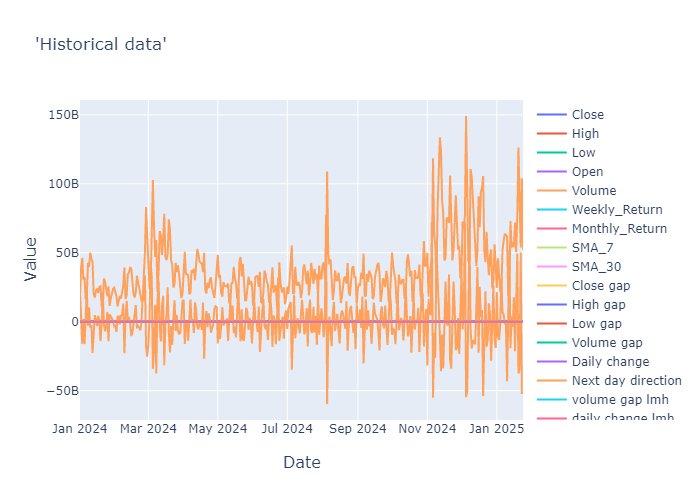

In [14]:
fig = make_subplots(rows=1, cols=1,x_title='Date',
                    y_title='Value')
for d in train_test_data:
    fig.add_trace((go.Scatter(x=train_test_data.index, y=train_test_data[d], name = d,connectgaps=False)), row=1, col=1)

fig.update_layout(title=dict(text="'Historical data'"))
fig.show()

## 📊 Correlation Analysis: Examining Relationships in Data

### 🧮 Compute Correlations

- `correlations = train_test_data.corr(method='pearson')`  
  - Calculates the correlation matrix for the `train_test_data` DataFrame.  
  - Uses the **Pearson** correlation method (other options: Spearman, Kendall).

In [15]:
correlations = train_test_data.corr(method='pearson') #spearman,pearson,kendall
print(correlations["Close"].sort_values(ascending=False))

Close                 1.000000
High                  0.997511
Low                   0.996740
Open                  0.993256
SMA_7                 0.988439
SMA_30                0.942758
Volume                0.581721
Monthly_Return        0.321431
Weekly_Return         0.157127
High gap              0.065240
Close gap             0.061003
Daily change          0.060086
Low gap               0.059451
volume gap lmh        0.029717
Volume gap            0.005337
daily change lmh     -0.003257
Next day direction   -0.025842
Name: Close, dtype: float64


## 📏 Data Normalization: Min-Max Scaling

### 📊 Normalize the Data

- `kl = train_test_data`  
  - Assigns the `train_test_data` DataFrame to the variable `kl`.

- `klminmax = (kl - kl.min()) / (kl.max() - kl.min())`  
  - Applies **Min-Max scaling** to normalize the data in `kl`.  
  - Subtracts the minimum value of each column (`kl.min()`).  
  - Divides by the range of each column (`kl.max() - kl.min()`).  
  - Results in values scaled between 0 and 1, stored in `klminmax`.

In [16]:
kl=train_test_data
klminmax=(kl-kl.min())/(kl.max()-kl.min())

### Data Visualization
This cell creates visualizations to explore the data.

## 📈 Visualization: Plotting Normalized Data (External vs Price)

### 🖼️ Plot Setup

- `fig = make_subplots(rows=1, cols=1, x_title='Date', y_title='Value')`  
  - Creates a single subplot with 1 row and 1 column.  
  - Labels the x-axis as "Date" and the y-axis as "Value".

### 📉 Adding Data Traces

- `for d in klminmax:`  
  - Iterates over each column in the `klminmax` DataFrame (normalized data).

- `fig.add_trace((go.Scatter(x=klminmax.index, y=klminmax[d], name=d, connectgaps=False)), row=1, col=1)`  
  - Adds a scatter plot (line) for each column.  
  - Plots the DataFrame's index on the x-axis and the normalized column values on the y-axis.  
  - Names each line using the column name.  
  - Disables connecting gaps in the data.

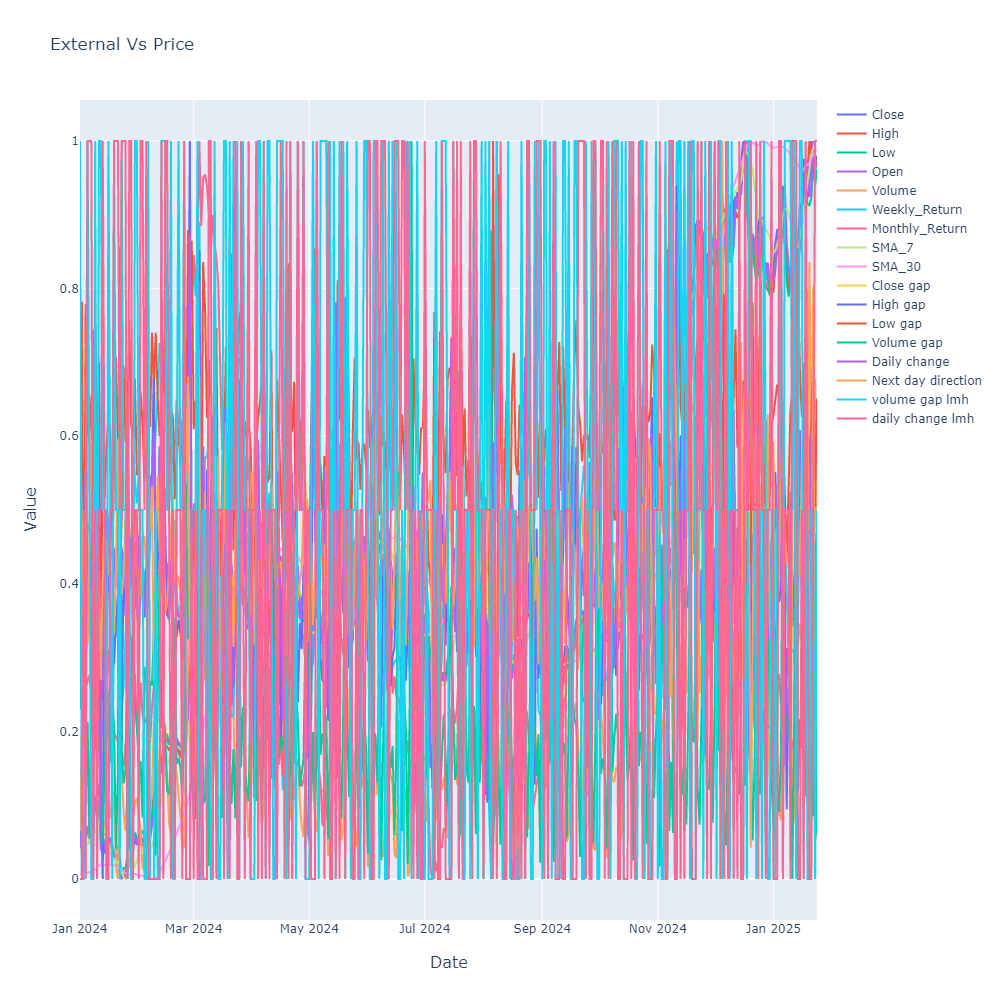

In [17]:
fig = make_subplots(rows=1, cols=1,x_title='Date',
                    y_title='Value')
for d in klminmax:
    fig.add_trace((go.Scatter(x=klminmax.index, y=klminmax[d], name = d,connectgaps=False)), row=1, col=1)

fig.update_layout(title=dict(text="External Vs Price"),height=1000, width=1000)
fig.show()

## 📈 Visualization: Plotting Bitcoin Close Price Over Time

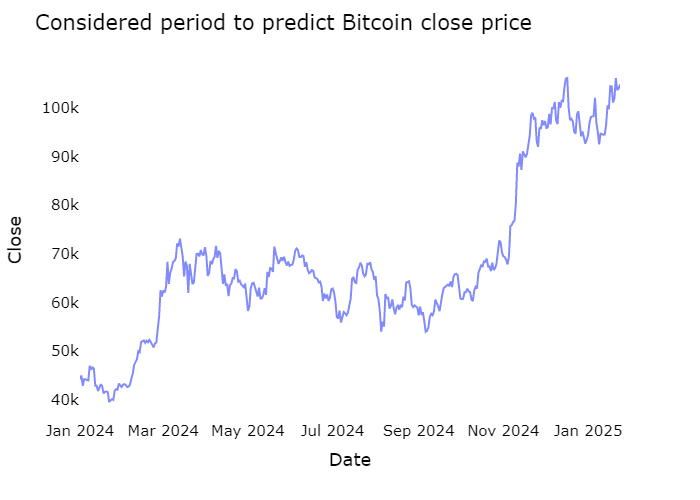

In [18]:
fig = px.line(train_test_data, x=train_test_data.index, y=train_test_data.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Bitcoin close price',
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## 🛠️ Importing Libraries for Probabilistic Modeling

This section imports the necessary libraries and modules for performing probabilistic modeling, Bayesian inference, and numerical computations using JAX and NumPyro.

### 📦 Library Imports

- `import numpy as np`  
  - Imports the **NumPy** library, a fundamental package for numerical computing in Python.  
  - Provides support for arrays, mathematical functions, and linear algebra.  
  - Aliased as `np` for convenience.

- `import jax.numpy as jnp`  
  - Imports **JAX's NumPy-compatible library**, which provides array operations optimized for hardware acceleration (e.g., GPU/TPU).  
  - Similar to NumPy but supports automatic differentiation and just-in-time (JIT) compilation.  
  - Aliased as `jnp` to distinguish it from `np`.

- `from jax import random`  
  - Imports the **random** module from JAX.  
  - Provides functions for generating random numbers in a way compatible with JAX's functional programming paradigm.  
  - Used for sampling in probabilistic models.

- `import numpyro`  
  - Imports **NumPyro**, a lightweight probabilistic programming library built on top of JAX.  
  - Enables defining and performing inference on probabilistic models with a focus on Bayesian methods.

- `from numpyro.contrib.control_flow import scan`  
  - Imports the `scan` function from NumPyro's **control flow utilities**.  
  - Allows for iterative computations (e.g., looping) in a functional way, compatible with JAX's compilation.

- `import numpyro.distributions as dist`  
  - Imports the **distributions** module from NumPyro.  
  - Provides a collection of probability distributions (e.g., Normal, Beta, etc.) for defining probabilistic models.

- `from jax import random, lax`  
  - Imports the `random` module (already imported) and the `lax` module from JAX.  
  - `lax` (Lower-level API for XLA) provides low-level operations like `scan` for efficient iterative computations.  
  - Used for fine-grained control over JAX's operations.

- `from numpyro.infer import MCMC, NUTS`  
  - Imports inference tools from NumPyro's `infer` module:  
    - `MCMC`: Provides Markov Chain Monte Carlo methods for sampling from posterior distributions.  
    - `NUTS`: Implements the No-U-Turn Sampler, an efficient variant of Hamiltonian Monte Carlo for Bayesian inference.

In [19]:
import numpy as np
import jax.numpy as jnp
from jax import random
import numpyro
from numpyro.contrib.control_flow import scan  # Import NumPyro's scan
import numpyro.distributions as dist
from jax import random, lax  # Import lax for scan
from numpyro.infer import MCMC, NUTS

## 🔧 Executing Code Block
**Purpose:**
- Perform a specific task such as transformation, cleaning, or computation.
**Outcome:**
- Contributes to overall data pipeline or analysis.

In [20]:
close_data=train_test_data.copy()

## 📊 Feature Engineering for Time Series Forecasting

This section of the code focuses on preparing the `close_data` DataFrame for time series modeling by creating **log-transformed** and **lag features**, which are essential for capturing temporal dependencies.

**This line creates a new column "Log_Close", which is the natural logarithm of the Close price.**

**Purpose:**
- Stabilizes the variance (especially useful when the Close price exhibits exponential growth).

- Makes the time series more stationary, which is beneficial for many forecasting models.


**This loop creates lagged versions of the Close price column.**

**Features Created**:

- Close_Lag_1: Close price shifted by 1 time step

- Close_Lag_2: Close price shifted by 2 time steps

- Close_Lag_3: Close price shifted by 3 time steps

**Purpose**:

- Enables models to learn from historical values.

- Useful for capturing autocorrelation and temporal patterns in the data.

**Removing Missing Values:**
- After shifting, the first few rows will contain NaN values. `close_data.dropna(inplace=True)`

- This line drops rows with missing values to avoid errors during model training.

In [21]:
# Feature Engineering
close_data['Log_Close'] = np.log(close_data['Close'])
for lag in range(1, 4):
    close_data[f'Close_Lag_{lag}'] = close_data['Close'].shift(lag)
close_data.dropna(inplace=True)

In [22]:
close_data['Log_Close']

Date
2024-01-04    10.696026
2024-01-05    10.695636
2024-01-06    10.691699
2024-01-07    10.690651
2024-01-08    10.757275
                ...    
2025-01-20    11.532891
2025-01-21    11.572573
2025-01-22    11.548805
2025-01-23    11.551763
2025-01-24    11.559995
Name: Log_Close, Length: 387, dtype: float64

## 📊 Correlation Analysis for Feature Selection

This section analyzes the **correlation structure** of the features in the `close_data` DataFrame to identify variables that are strongly associated with the `Log_Close` price (our target variable).

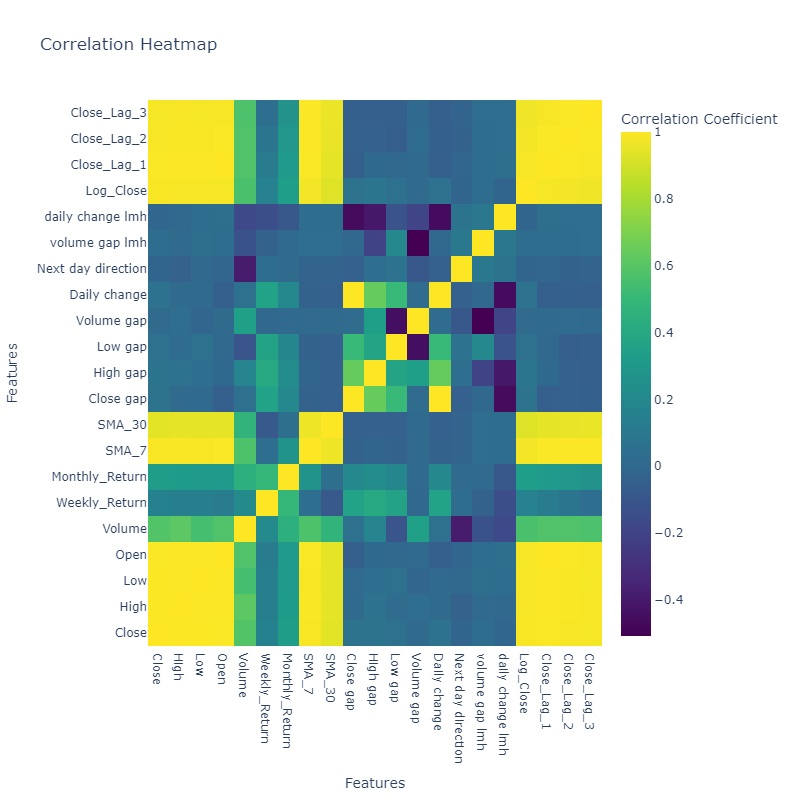

Log_Close             1.000000
Close                 0.988862
High                  0.986440
Low                   0.985496
Open                  0.982291
Close_Lag_1           0.982278
SMA_7                 0.977390
Close_Lag_2           0.976269
Close_Lag_3           0.969767
SMA_30                0.931276
Volume                0.561535
Monthly_Return        0.329082
Weekly_Return         0.161907
High gap              0.076455
Close gap             0.062855
Daily change          0.061873
Low gap               0.054644
volume gap lmh        0.029332
Volume gap            0.014529
Next day direction   -0.019857
daily change lmh     -0.022012
Name: Log_Close, dtype: float64


In [23]:
# Assuming `train_test_data` is your DataFrame
correlations = close_data.corr(method='pearson')  # Compute correlation matrix
close_corr = correlations["Log_Close"].sort_values(ascending=False)  # Correlation with "Close"

# Create a full heatmap for all correlations
fig = go.Figure(
    data=go.Heatmap(
        z=correlations.values,  # Correlation values
        x=correlations.columns,  # Feature names (x-axis)
        y=correlations.index,  # Feature names (y-axis)
        colorscale="Viridis",  # Colorscale for heatmap
        colorbar=dict(title="Correlation Coefficient")  # Colorbar title
    )
)

# Update layout
fig.update_layout(
    title="Correlation Heatmap",
    xaxis=dict(title="Features"),
    yaxis=dict(title="Features"),
    width=800,
    height=800
)

fig.show()
print(close_corr)

## 🧪 Splitting the Dataset into Training and Testing Sets

This section focuses on splitting the time series data into **training** and **testing** sets based on a specific date. This approach ensures that future data (testing) is never used to predict the past (training), which is essential in time series forecasting.


In [24]:
end_train=dt.datetime(2025,1,15)
train_data=close_data.loc[(close_data.index>=start_date ) & (close_data.index<=end_train) ]
test_data=close_data.loc[(close_data.index>end_train )]

In [25]:
test_data

,Close,High,Low,Open,Volume,Weekly_Return,Monthly_Return,SMA_7,SMA_30,Close gap,...,Low gap,Volume gap,Daily change,Next day direction,volume gap lmh,daily change lmh,Log_Close,Close_Lag_1,Close_Lag_2,Close_Lag_3
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-16,99756.906250,100781.585938,97364.445312,100505.296875,54103781805,0.078639,-0.060144,96438.350446,96418.953906,-0.007438,...,0.008941,-0.064044,-0.007446,1.778519e+10,2,1,11.510492,100504.492188,96534.046875,94516.523438
2025-01-17,104462.039062,105884.226562,99948.906250,100025.765625,71888972663,0.103067,0.044187,97832.719866,96566.303906,0.047166,...,0.026544,0.328724,0.044351,-2.144332e+10,0,0,11.556579,99756.906250,100504.492188,96534.046875
2025-01-18,104408.070312,104913.203125,102226.617188,104124.953125,50445655726,0.104069,0.070951,99238.645089,96796.874479,-0.000517,...,0.022789,-0.298284,0.002719,2.634427e+10,1,2,11.556062,104462.039062,99756.906250,100504.492188
2025-01-19,101089.609375,106299.796875,99570.531250,104411.289062,76789928525,0.069862,0.034102,100181.669643,96907.997135,-0.031784,...,-0.025982,0.522231,-0.031813,4.948975e+10,0,1,11.523763,104408.070312,104462.039062,99756.906250
2025-01-20,102016.664062,109114.882812,99471.359375,101083.750000,126279678351,0.079353,0.049287,101253.118304,97067.728385,0.009171,...,-0.000996,0.644482,0.009229,-3.754580e+10,0,0,11.532891,101089.609375,104408.070312,104462.039062
2025-01-21,106146.265625,107180.921875,100103.953125,102052.578125,88733878242,0.099573,0.116096,102626.292411,97435.772656,0.040480,...,0.006360,-0.297323,0.040114,-3.485570e+10,1,0,11.572573,102016.664062,101089.609375,104408.070312
2025-01-22,103653.070312,106294.343750,103360.265625,106136.382812,53878181052,0.031328,0.094700,103076.089286,97734.666927,-0.023488,...,0.032529,-0.392812,-0.023397,5.022633e+10,1,1,11.548805,106146.265625,102016.664062,101089.609375
2025-01-23,103960.171875,106820.328125,101257.804688,103657.671875,104104515428,0.042135,0.053550,103676.555804,97910.802865,0.002963,...,-0.020341,0.932220,0.002918,-5.171629e+10,0,2,11.551763,103653.070312,106146.265625,102016.664062
2025-01-24,104819.484375,107098.546875,102772.125000,103965.671875,52388229265,0.003422,0.055592,103727.619420,98094.812500,0.008266,...,0.014955,-0.496773,0.008212,-5.171629e+10,1,2,11.559995,103960.171875,103653.070312,106146.265625


## 🧠 Training Machine Learning Model
## ⚙️ Feature and Target Selection + Data Scaling
**Purpose:**
- Defines the input features (features) and target variable (Log_Close) for the model.
- Splits both training and testing datasets into features and labels to prepare for modeling.

## 🔄 Standardize the Feature Data

**Purpose:**
- Applies z-score normalization using StandardScaler.
- Ensures that all features have a mean of 0 and standard deviation of 1, which helps many ML algorithms converge faster and perform better.

In [26]:
features = ['High', 'Low', 'Open', 'SMA_7', 'Volume', 'SMA_30','Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3']
target = 'Log_Close'
train_external=train_data[features]
train_label=train_data[target]
test_external=test_data[features]
test_label=test_data[target]

# Scale the data
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_external)
scaled_test_data = scaler.transform(test_external)


## 🧠 Bayesian State-Space Model with Exogenous Features

This section builds a **Bayesian time series model** using **NumPyro**. The model combines the strength of an **AR(1) process**, **external features (regressors)**, and a **seasonal component**, making it well-suited for **financial time series forecasting**.

**What This Does:**
- process_std: Controls the latent state noise (process uncertainty).

- noise_std: Controls the observation noise (measurement uncertainty).

- beta: Coefficients for external features, drawn from a Laplace prior (L1 regularization).

- seasonal: Captures seasonal fluctuations, modeled for 4 quarters.

- latent_states: Models the hidden AR(1) process, integrating both past value, seasonality, and external inputs.

- obs: Defines the observation likelihood as a Student-T distribution, robust to outliers.

## 🧪 Prepare the Training Data for MCMC
**Purpose:**
- `T_train:` Total number of time steps for training.

- `observations_train:` Target values to be modeled (log-transformed closing prices).

- `scaled_train_jax:` Scaled features, converted to JAX arrays for NumPyro compatibility.

## 🔁 Run MCMC Sampling with NUTS

**Purpose:**
- Uses **No-U-Turn Sampler (NUTS)** — an adaptive version of HMC — for efficient exploration of the posterior.

- `num_warmup:` Number of tuning iterations to adapt the sampler.

- `num_samples:` Number of posterior samples to draw.

- `posterior_samples:` Contains the posterior distributions for model parameters and latent states.

## 📊 Prepare the Test Set for Prediction

**Purpose:**
- Defines the number of time steps in the **test period** `(T_test)`.

- Converts the scaled test feature matrix to a **JAX array**, ready for prediction or forecasting tasks using posterior samples.

In [27]:
# Define the Bayesian State-Space Model
def state_space_model_with_features(T, X, obs=None):
    process_std = numpyro.sample("process_std", dist.HalfNormal(0.5))
    noise_std = numpyro.sample("noise_std", dist.HalfNormal(0.5))
    beta = numpyro.sample("beta", dist.Laplace(0, 0.1).expand([X.shape[1]]))

    # Seasonal component (e.g., quarterly)
    seasonal = numpyro.sample("seasonal", dist.Normal(0, 1).expand([4]))

    # AR(1) state transition + features + seasonality
    x0 = numpyro.sample("x0", dist.Normal(0, 1))
    latent_states = [x0]
    for t in range(1, T):
        season = seasonal[t % 4]
        x_prev = latent_states[t-1]
        x_mean = 0.8 * x_prev + jnp.dot(X[t-1], beta) + season  # AR(1) coefficient = 0.8
        x_t = numpyro.sample(f"x_{t}", dist.Normal(x_mean, process_std))
        latent_states.append(x_t)

    # Robust observation model
    numpyro.sample("obs", dist.StudentT(4, jnp.array(latent_states), noise_std), obs=obs)

# Prepare the training dataset
T_train = len(train_label)
observations_train = train_label.values
scaled_train_jax = jnp.array(scaled_train_data)

# Run MCMC
rng_key = random.PRNGKey(0)
nuts_kernel = NUTS(state_space_model_with_features,target_accept_prob=0.9)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(rng_key, T=T_train, X=scaled_train_jax, obs=observations_train)
posterior_samples = mcmc.get_samples()

# Predict on the test set
T_test = len(test_label)
scaled_test_jax = jnp.array(scaled_test_data)

sample: 100%|██████████| 1500/1500 [15:02<00:00,  1.66it/s, 511 steps of size 8.24e-03. acc. prob=0.94] 


## 🔮 Posterior Predictions & Visualization with Credible Intervals

This section generates **posterior predictions** using the trained Bayesian model and visualizes both the **training** and **testing forecasts** with **95% credible intervals**. The model outputs predictions in the **log-transformed space** (i.e., `Log_Close`).

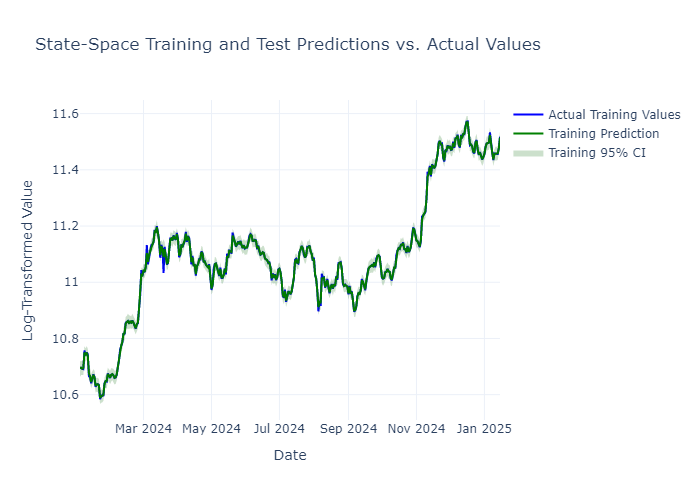

In [33]:
# Get the number of sampled latent states. This is CRUCIAL.
num_latent_states = len(posterior_samples["x_1"])

# Predictions and Credible Intervals using Predictive
posterior_predictive = numpyro.infer.Predictive(state_space_model_with_features, posterior_samples=posterior_samples)
predictions = posterior_predictive(rng_key, T=len(close_data), X=jnp.concatenate([scaled_train_jax, scaled_test_jax]))['obs']
predictions_np = np.array(predictions)

mean_predictions = np.mean(predictions_np, axis=0)
lower_bounds = np.percentile(predictions_np, 2.5, axis=0)
upper_bounds = np.percentile(predictions_np, 97.5, axis=0)

train_predictions = mean_predictions[:len(train_label)]
test_predictions = mean_predictions[len(train_label):]
train_lower = lower_bounds[:len(train_label)]
test_lower = lower_bounds[len(train_label):]
train_upper = upper_bounds[:len(train_label)]
test_upper = upper_bounds[len(train_label):]


# Plotting with actual values using original timestamps
train_timestamps = train_data.index
test_timestamps = test_data.index

fig = go.Figure()

# Training data
fig.add_trace(go.Scatter(x=train_timestamps, y=train_label, mode='lines', name='Actual Training Values', line=dict(color='blue')))

# Training predictions (Keep in log form, no exponentiation)
fig.add_trace(go.Scatter(x=train_timestamps, y=train_predictions, mode='lines', name='Training Prediction', line=dict(color='green')))
fig.add_trace(go.Scatter(x=np.concatenate([train_timestamps, train_timestamps[::-1]]), y=np.concatenate([train_upper, train_lower[::-1]]), fill='toself', fillcolor='rgba(0,100,0,0.2)', line=dict(color='rgba(0,100,0,0)'), name='Training 95% CI'))


fig.update_layout(title="State-Space Training and Test Predictions vs. Actual Values", xaxis_title="Date", yaxis_title="Log-Transformed Value", template="plotly_white")
fig.show()


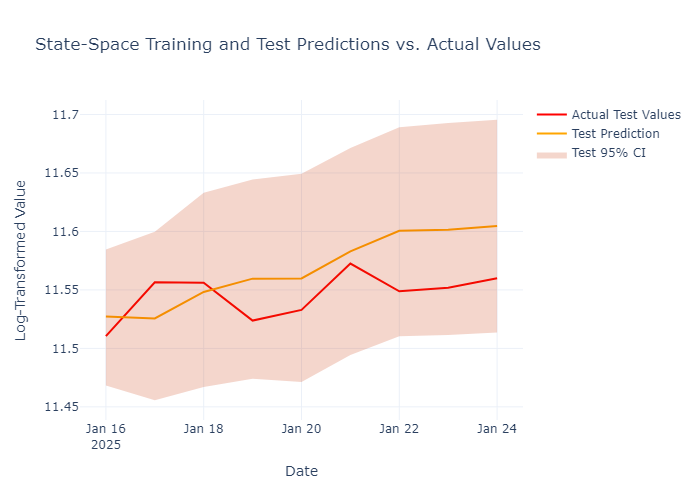

In [36]:
fig2 = go.Figure()
# Test data
fig2.add_trace(go.Scatter(x=test_timestamps, y=test_label, mode='lines', name='Actual Test Values', line=dict(color='red')))

# Test predictions (Keep in log form, no exponentiation)
fig2.add_trace(go.Scatter(x=test_timestamps, y=test_predictions, mode='lines', name='Test Prediction', line=dict(color='orange')))
fig2.add_trace(go.Scatter(x=np.concatenate([test_timestamps, test_timestamps[::-1]]), y=np.concatenate([test_upper, test_lower[::-1]]), fill='toself', fillcolor='rgba(200,50,0,0.2)', line=dict(color='rgba(200,50,0,0)'), name='Test 95% CI'))

fig2.update_layout(title="State-Space Training and Test Predictions vs. Actual Values", xaxis_title="Date", yaxis_title="Log-Transformed Value", template="plotly_white")
fig2.show()

## 📋 Posterior Summary Statistics: Coefficients & Uncertainty

This section summarizes the **posterior distributions** of key model parameters, including:

- Regression coefficients (`beta`)
- Process standard deviation (`process_std`)
- Observation noise standard deviation (`noise_std`)

The results are displayed in tabular format with **mean**, **median**, and **95% credible intervals**.

In [29]:
# Coefficient Statistics in Table Form
beta_samples = posterior_samples['beta']
process_std_samples = posterior_samples['process_std']
noise_std_samples = posterior_samples['noise_std']

# Beta Coefficients Table
df_beta = pd.DataFrame(beta_samples)
num_coef = df_beta.shape[1]
results_beta = []
for i in range(num_coef):
    coef_samples = df_beta[i].values
    mean_coef = np.mean(coef_samples)
    median_coef = np.median(coef_samples)
    lower_ci = np.percentile(coef_samples, 2.5)
    upper_ci = np.percentile(coef_samples, 97.5)
    results_beta.append([mean_coef, median_coef, lower_ci, upper_ci])

columns = ['Mean', 'Median', 'Lower CI (2.5%)', 'Upper CI (97.5%)']
table_beta = pd.DataFrame(results_beta, columns=columns)
table_beta.index.name = "Beta Coefficient"
print("Beta Coefficients:")
print(table_beta)

# Process Std Table
results_process_std = []
mean_process_std = np.mean(process_std_samples)
median_process_std = np.median(process_std_samples)
lower_ci_process_std = np.percentile(process_std_samples, 2.5)
upper_ci_process_std = np.percentile(process_std_samples, 97.5)
results_process_std.append([mean_process_std, median_process_std, lower_ci_process_std, upper_ci_process_std])
table_process_std = pd.DataFrame(results_process_std, columns=columns, index=["Process Std"])
print("\nProcess Standard Deviation:")
print(table_process_std)

# Noise Std Table
results_noise_std = []
mean_noise_std = np.mean(noise_std_samples)
median_noise_std = np.median(noise_std_samples)
lower_ci_noise_std = np.percentile(noise_std_samples, 2.5)
upper_ci_noise_std = np.percentile(noise_std_samples, 97.5)
results_noise_std.append([mean_noise_std, median_noise_std, lower_ci_noise_std, upper_ci_noise_std])
table_noise_std = pd.DataFrame(results_noise_std, columns=columns, index=["Noise Std"])
print("\nNoise Standard Deviation:")
print(table_noise_std)

Beta Coefficients:
                      Mean    Median  Lower CI (2.5%)  Upper CI (97.5%)
Beta Coefficient                                                       
0                 0.039616  0.038775        -0.018456          0.100955
1                 0.050803  0.050814         0.004171          0.103141
2                -0.024371 -0.021819        -0.177896          0.127841
3                 0.000225 -0.000015        -0.042173          0.043925
4                 0.002977  0.002869        -0.003033          0.009213
5                 0.000991  0.000956        -0.009216          0.011850
6                -0.013558 -0.012368        -0.163669          0.134926
7                -0.025688 -0.025834        -0.058242          0.005398
8                 0.013431  0.012846        -0.017401          0.045366

Process Standard Deviation:
                    Mean    Median  Lower CI (2.5%)  Upper CI (97.5%)
Process Std  0.025730835  0.025668         0.022619          0.028849

Noise Standard Devi

## 📉 Trace Plot for Beta Coefficients

This section visualizes the **sampling trajectories** of the `beta` coefficients from the posterior distribution using a **trace plot**. This diagnostic helps assess the **convergence** of the Markov Chain Monte Carlo (MCMC) sampler.

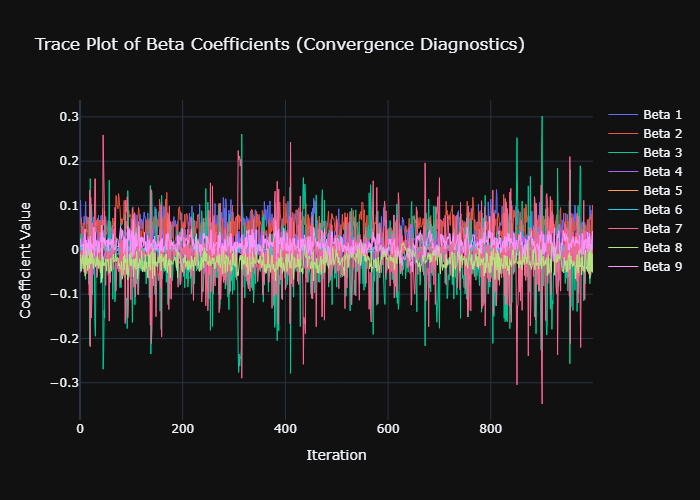

In [30]:
# Extract beta samples for trace plot
df_beta_trace = pd.DataFrame(beta_samples)
num_coef = df_beta_trace.shape[1]

# Create a trace plot for each beta coefficient
fig = go.Figure()

for i in range(num_coef):
    fig.add_trace(
        go.Scatter(
            y=df_beta_trace[i],
            mode='lines',
            name=f'Beta {i+1}',
            line=dict(width=1)
        )
    )

# Layout adjustments for trace plot
fig.update_layout(
    title="Trace Plot of Beta Coefficients (Convergence Diagnostics)",
    xaxis_title="Iteration",
    yaxis_title="Coefficient Value",
    template="plotly_dark"
)

fig.show()

## 📊 Trace and Density Plots for Model Parameters

This section visualizes both **trace plots** and **density plots** (including Kernel Density Estimate, KDE) for key model parameters, including the `beta` coefficients, process standard deviation (`process_std`), and noise standard deviation (`noise_std`). These plots help evaluate the **convergence** of the MCMC chains and provide insight into the **distribution** of each parameter.

---

### 🧪 Function Overview

The function `plot_trace_and_density_plotly` generates two interactive plots for each parameter:
1. **Trace Plot**: Shows how the parameter values evolve across MCMC iterations.
2. **Density Plot**: Displays the **probability density** of the parameter, including a **KDE** to smooth the distribution.

---

### 📈 Trace Plot
The trace plot for each parameter (e.g., `beta[1]`, `process_std`, `noise_std`) shows how the MCMC chain explores the parameter space over time (iterations).

- **Good Convergence**: If the chain mixes well and oscillates around the mean without getting stuck or drifting, it suggests that the MCMC has converged.
- **Bad Convergence**: A poor convergence may show flat, non-varying values, indicating that the chain is not properly exploring the parameter space.

---

### 📊 Density Plot
The density plot shows the **probability distribution** of the parameter values, computed by:
- A **histogram** that captures the empirical density.
- A **Kernel Density Estimate (KDE)** that provides a smooth approximation of the underlying distribution.

---

### 👀 Visual Results

For each parameter:
1. **Beta Coefficients (`beta[1]`, `beta[2]`, ..., `beta[n]`)**
   - **Trace Plot**: Displays how the coefficient values evolve over the MCMC iterations.
   - **Density Plot**: Visualizes the distribution of each coefficient, including the smooth KDE curve to estimate the underlying distribution of each parameter.

2. **Process Standard Deviation (`Process Std`)**
   - **Trace Plot**: Shows how the uncertainty in the latent state process varies with MCMC iterations.
   - **Density Plot**: Shows the distribution of the estimated process standard deviation. A peak at a certain value suggests where the process variance is most likely.

3. **Noise Standard Deviation (`Noise Std`)**
   - **Trace Plot**: Displays how the model’s observation noise parameter evolves over the iterations.
   - **Density Plot**: Illustrates the distribution of noise variance, allowing you to assess the model's sensitivity to data noise.

---

### 🔎 Interpretation of Plots

1. **Trace Plots**:
   - Ensure that the chains mix well and the parameters are not stuck in one region.
   - Ideally, the plot should show **random oscillations** around the mean, indicating that the chain is exploring the parameter space well.

2. **Density Plots**:
   - Show the distribution of each parameter.
   - The KDE provides a smooth estimate of the distribution, which is useful for understanding the spread and central tendency of each parameter.

> ✅ These diagnostic plots are key for understanding the **model convergence** and **parameter distributions**, helping us ensure reliable inference.


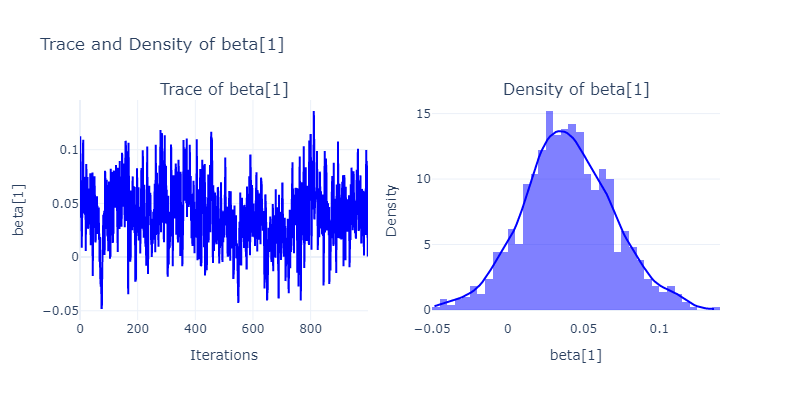

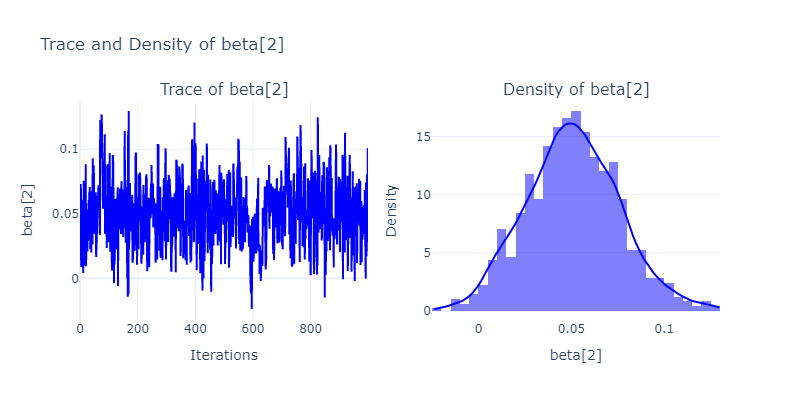

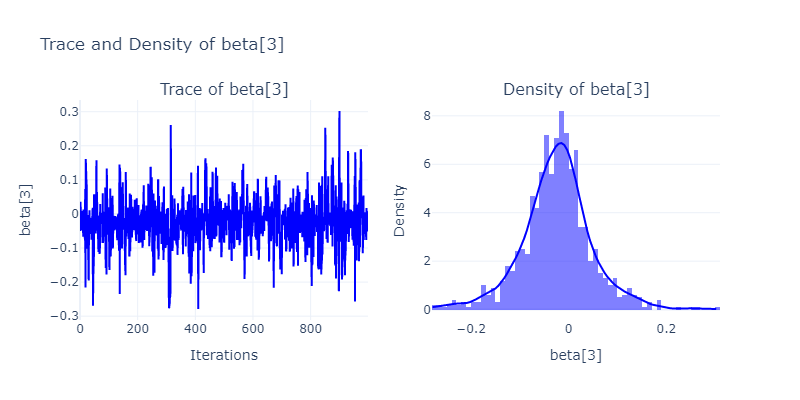

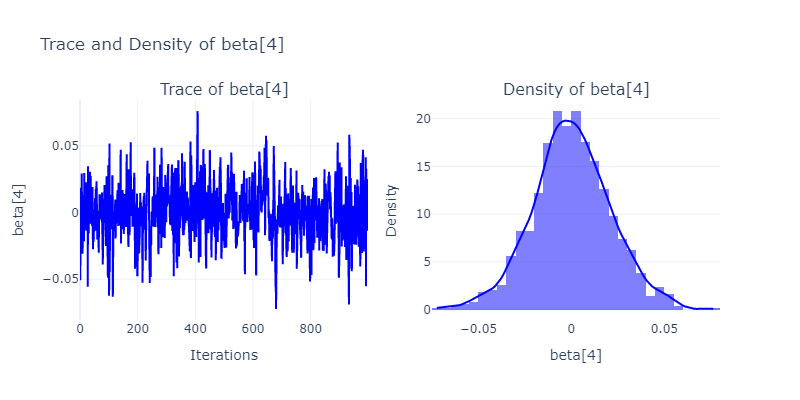

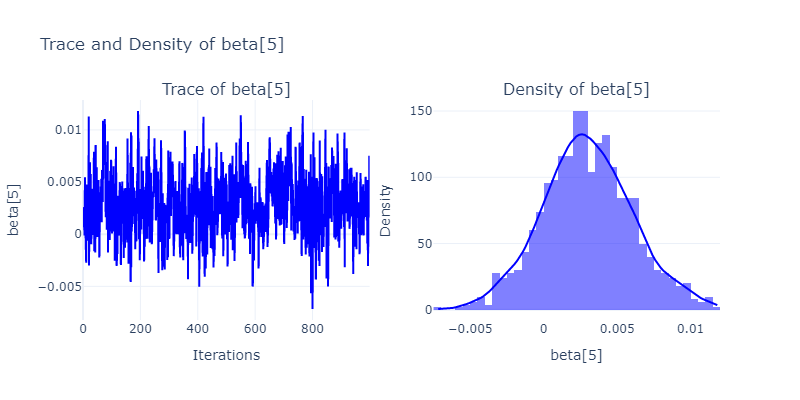

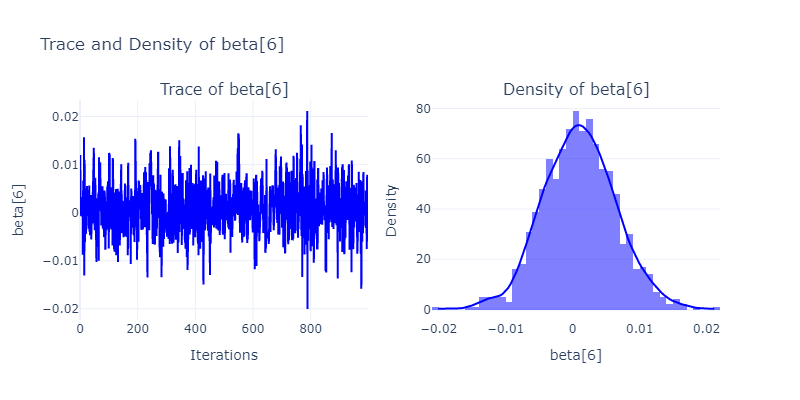

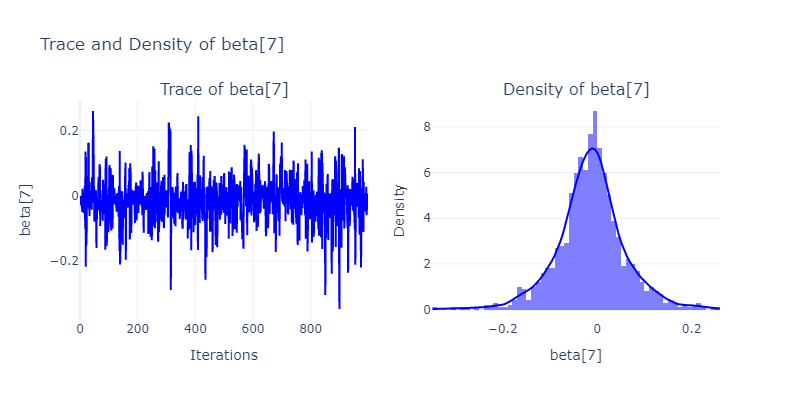

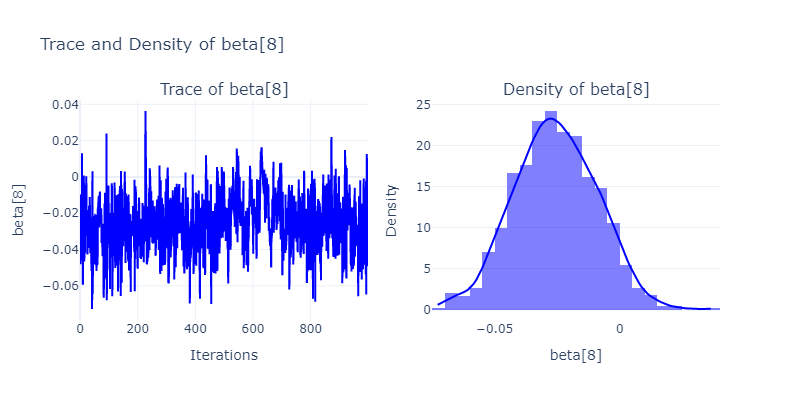

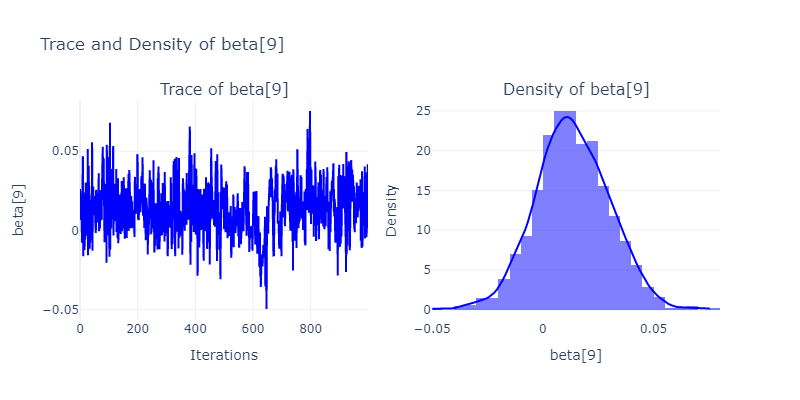

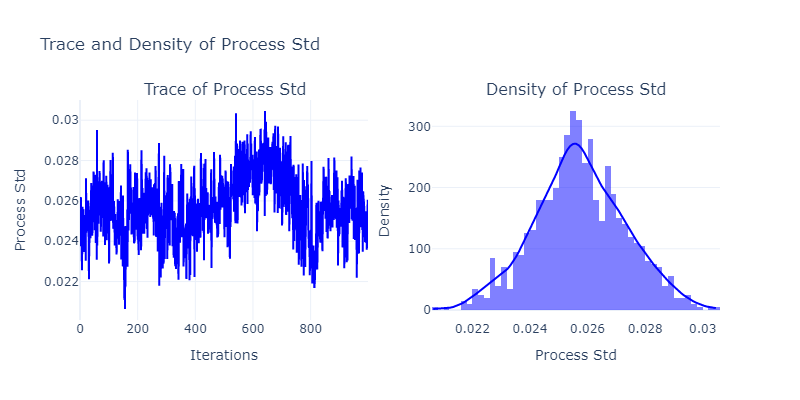

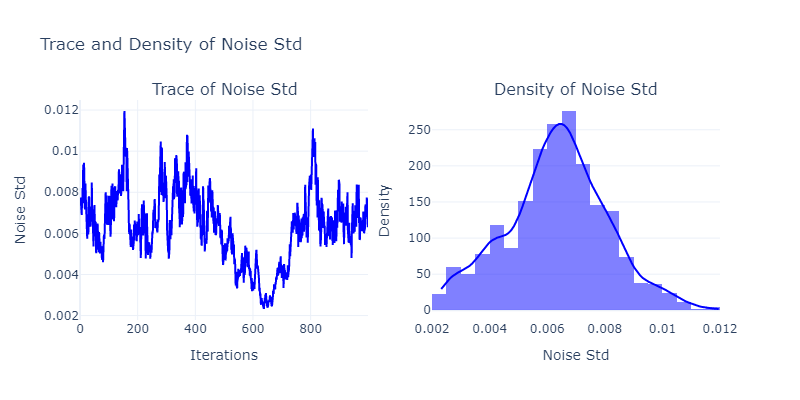

In [31]:
from scipy.stats import gaussian_kde
def plot_trace_and_density_plotly(samples, param_name):
    """
    Create interactive trace and density plots using Plotly.
    """
    # Create a subplot: Left = Trace plot, Right = Density plot
    fig = make_subplots(rows=1, cols=2, subplot_titles=(f"Trace of {param_name}", f"Density of {param_name}"))

    # Trace plot
    fig.add_trace(
        go.Scatter(y=samples, mode='lines', name=f'Trace of {param_name}',
                   line=dict(color='blue'), showlegend=False),
        row=1, col=1
    )

    # Density plot (Histogram + KDE)
    fig.add_trace(
        go.Histogram(x=samples, histnorm='probability density', name=f'Density of {param_name}',
                     marker=dict(color='blue', opacity=0.5), showlegend=False),
        row=1, col=2
    )

    # Add KDE (Kernel Density Estimate)
    kde = gaussian_kde(samples)
    x_vals = np.linspace(min(samples), max(samples), 100)
    kde_vals = kde(x_vals)

    fig.add_trace(
        go.Scatter(x=x_vals, y=kde_vals, mode='lines', name=f'KDE of {param_name}',
                   line=dict(color='blue'), showlegend=False),
        row=1, col=2
    )

    # Layout adjustments
    fig.update_layout(
        title=f"Trace and Density of {param_name}",
        template="plotly_white",
        height=400,
        width=800,
        xaxis_title="Iterations",
        xaxis2_title=param_name,
        yaxis_title=param_name,
        yaxis2_title="Density"
    )

    fig.show()


# Plot for each beta coefficient
for i in range(beta_samples.shape[1]):
    plot_trace_and_density_plotly(beta_samples[:, i], f'beta[{i+1}]')

# Plot for process standard deviation
plot_trace_and_density_plotly(process_std_samples, 'Process Std')

# Plot for noise standard deviation
plot_trace_and_density_plotly(noise_std_samples, 'Noise Std')

## 📊 Model Evaluation Metrics

This section calculates and displays the **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** for both the **training** and **test** sets. These metrics are used to assess the performance of the model in predicting the target variable.


In [32]:
# Metrics
mse1 = mean_squared_error(train_label.values, train_predictions)
mae1 = mean_absolute_error(train_label.values, train_predictions)
mse = mean_squared_error(test_label.values, test_predictions)
mae = mean_absolute_error(test_label.values, test_predictions)
print(f"MSE: {mse1:.4f}, MAE: {mae1:.4f}",f"MSE: {mse:.4f}, MAE: {mae:.4f}")

MSE: 0.0000, MAE: 0.0026 MSE: 0.0012, MAE: 0.0305
